# <div style="text-align:center;">**Capuchin Bird Signal Processing**</div>

# 1. Load Dependencies

I was originally running this locally. Nevertheless, due to higher RAM requirements, I had to run it externally and for that purpose, I use Google Colab. I still forced the import of tensorflow 2.8.0 and tensorflow_io 0.24.0. When running it locally, I ued python 3.8.6 in a venv to install said libraries, but you might be able to install these versions using python 3.11.

For some reason tf.audio.decode_wav does not work with tensorflow 2.14.0. I couldn't install tensorflow 2.8.0 from python 3.11 so I am using python 3.8.6 to install the following dependencies.

In [1]:
%pip install matplotlib
%pip install tensorflow==2.8.0
%pip install tensorflow_io==0.24.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 93.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 82.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 99.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 66.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing 

Furthermore, to be able to import tensorflow 2.8.0, the photobuf plugin needs to be downgraded to a version < 3.20.

In [2]:
%pip install protobuf==3.20

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.4.0 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
google-api-core 2.11.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0.dev0,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
google-cloud-aiplatform 1.38.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
google-cl

In [3]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import sys

In [4]:
print('tensorflow version:', tf.__version__)
print('tensorflow_io version:', tfio.__version__)
print(sys.version)

tensorflow version: 2.8.0
tensorflow_io version: 0.24.0
3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


Lets export the dependencies used in a txt file.

In [5]:
"""%pip freeze > requirements.txt"""

'%pip freeze > requirements.txt'

# 2. Data Collection

In [6]:
def load_data(file):
    try:
        # get the file extension of the file
        _, file_extension = os.path.splitext(file)
        if file_extension.lower() == '.mp3':
            # Read and decode the MP3 file
            res = tfio.audio.AudioIOTensor(file)
            wav = res.to_tensor()
            wav = tf.math.reduce_sum(wav, axis=1)/2
            sample_rate = res.rate

        elif file_extension.lower() == '.wav':
            # Read and decode the WAV file
            wav, sample_rate = tf.audio.decode_wav(tf.io.read_file(file), desired_channels=1)
            wav = tf.squeeze(wav, axis=-1)

    except TypeError: # bypass error when using map(spectrogram)
        print('mapping error bypassed')
        wav, sample_rate = tf.audio.decode_wav(tf.io.read_file(file), desired_channels=1)
        wav = tf.squeeze(wav, axis=-1)

    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)

    return wav

## 3. EDA

Lets use random library to sample some files from each of the folders and see what their respecitve waveforms look like.

A wavegform is essentially a time series plot with the signal amplitude at each instance.

In [7]:
from IPython import display
import random
import collections
random.seed(42) # pass a seed for reproducibility

In [8]:
# sample from the capuchin files
capu_folder_path = 'data/Parsed_Capuchinbird_Clips'
capu_files = os.listdir(capu_folder_path)
capu_sampled = random.sample(capu_files, 4)

display.display(display.Audio(load_data(os.path.join(capu_folder_path, capu_sampled[0])), rate=16000))

In [9]:
# sample from the non-capuchin files
non_capu_folder_path = 'data/Parsed_Not_Capuchinbird_Clips'
non_capu_files = os.listdir(non_capu_folder_path)
non_capu_sampled = random.sample(non_capu_files, 4)

display.display(display.Audio(load_data(os.path.join(non_capu_folder_path, non_capu_sampled[0])), rate=16000))

In [10]:
import re

In [11]:
def process_filename(filename):
    filename_without_extension = filename.replace('.wav', '')
    filename_without_number = re.sub(r'\D*(\d*)\.wav$', r'\1.wav', filename_without_extension)
    result_with_number = filename_without_number.replace('-', ' ')
    final_result = ''.join(char for char in result_with_number if not char.isdigit()).rstrip()
    return final_result

In [12]:
process_filename(non_capu_sampled[0])

'sparrow sound effect'

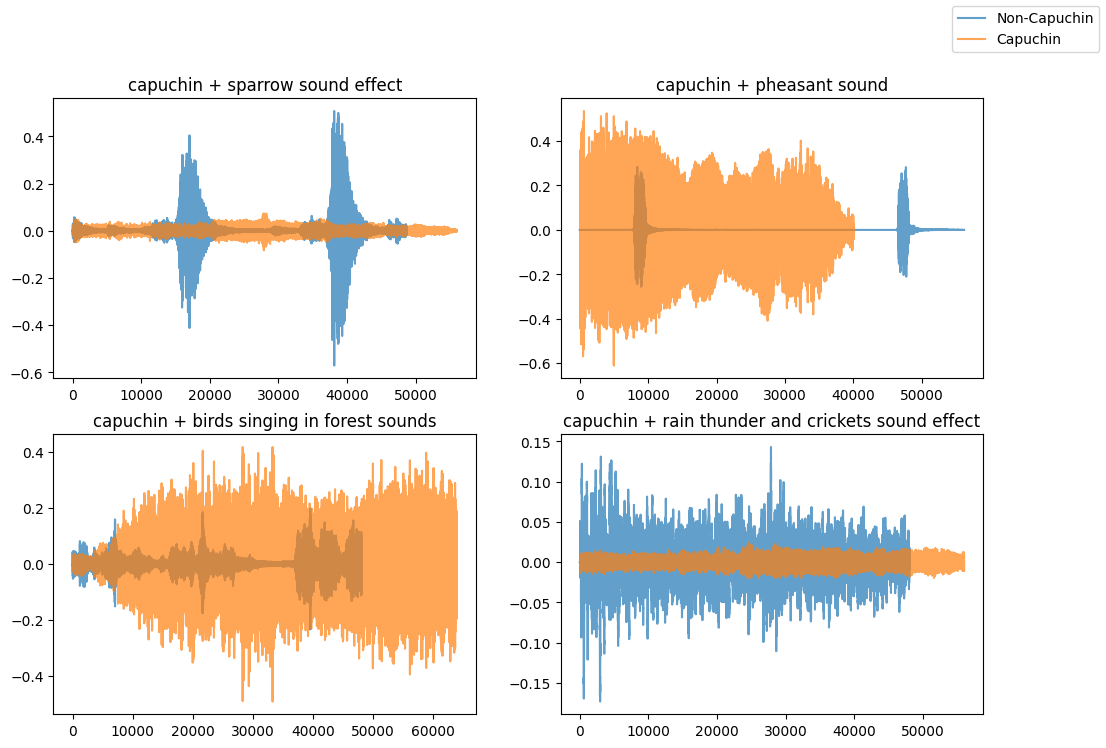

In [13]:
# plot the waveforms
fig, ax = plt.subplots(2,2, figsize=(12,8))
for i in range(4):
    ax[i//2, i%2].plot(load_data(os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', non_capu_sampled[i])), alpha=0.7)
    ax[i//2, i%2].plot(load_data(os.path.join('data', 'Parsed_Capuchinbird_Clips', capu_sampled[i])), alpha=0.7)
    ax[i//2, i%2].set_title('capuchin + {}'.format(process_filename(non_capu_sampled[i])))
fig.legend(['Non-Capuchin', 'Capuchin'], loc='upper right')

## Average waveform length

In [14]:
capu_length = []
for file in os.listdir(capu_folder_path):
    capu_length.append(len(load_data(os.path.join(capu_folder_path, file))))

print(collections.Counter(capu_length))
print(len(capu_length))

Counter({56000: 255, 48000: 174, 64000: 129, 40000: 51, 72000: 15, 32000: 12, 55999: 9, 39999: 3, 80000: 3})
651


Counter({48160: 55, 48304: 49, 48640: 39, 48031: 38, 48559: 28, 48175: 19, 48560: 19, 49295: 19, 48768: 16, 48928: 16, 48783: 14, 48703: 14, 48655: 13, 49311: 13, 49072: 12, 49056: 11, 48320: 11, 48032: 10, 50880: 9, 49696: 9, 50111: 9, 48912: 9, 49055: 8, 50431: 8, 48191: 7, 49071: 7, 50127: 7, 48911: 6, 49695: 5, 50895: 5, 52079: 5, 49712: 5, 51503: 5, 48576: 4, 52080: 4, 48767: 4, 53360: 4, 48927: 4, 49711: 3, 50112: 3, 49312: 3, 48176: 3, 53823: 3, 48144: 3, 48575: 2, 48687: 2, 51551: 2, 48192: 2, 54591: 2, 56207: 2, 58080: 2, 50128: 2, 55472: 2, 53359: 2, 51567: 2, 51279: 2, 50432: 2, 51488: 2, 60720: 1, 52063: 1, 47229: 1, 51568: 1, 55456: 1, 61423: 1, 54047: 1, 51296: 1, 52863: 1, 60719: 1, 54048: 1, 51487: 1, 49039: 1, 56192: 1, 53375: 1, 54032: 1, 52847: 1, 53808: 1, 51295: 1, 55471: 1, 54607: 1, 60735: 1, 52064: 1, 49040: 1, 56191: 1, 53807: 1, 63087: 1})
593


Text(0.5, 0, 'waveform length*16k')

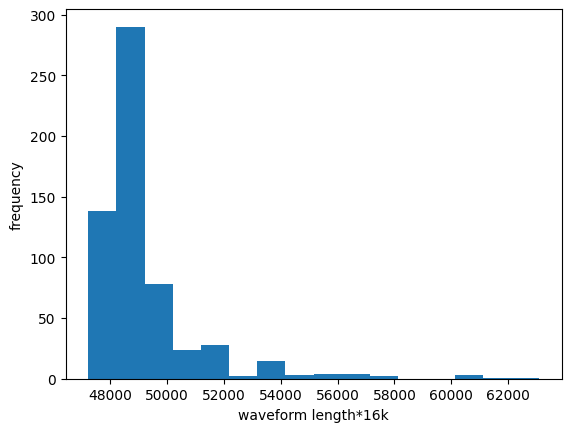

In [15]:
non_capu_length = []
for file in os.listdir(non_capu_folder_path):
    non_capu_length.append(len(load_data(os.path.join(non_capu_folder_path, file))))

print(collections.Counter(non_capu_length))
print(len(non_capu_length))
plt.hist(non_capu_length, bins=16)
plt.ylabel('frequency')
plt.xlabel('waveform length*16k')

## Observations

### 1. There is a class imbalance with capu:non_capu = 1:3.
Solution: We can fix this issue by oversampling our capuchin bird sounds.
### 2. The lengths of the recordings vary significantly
Solution: Most of the waveform lengths at least 3 seconds (48000 data points after sampling at 16000Hz). We can therefore cut all wavelengths to this length and use zero padding for the ones that are shorter than that

# 4. Preprocessing

## Oversampling

We can generate 2 more eqully sized capuchin training sets by using librosa library and slighly modifying the pitch of the capuchin bird recordings.

In [ ]:
%pip install librosa

'%pip install librosa'

In [16]:
import librosa

In [17]:
def pitch_amplification(wav, pitch_shift_factor):
    wav_shifted = librosa.effects.pitch_shift(wav.numpy(), sr=16000, n_steps=pitch_shift_factor)
    return wav_shifted

In [18]:
wav_orig = load_data(os.path.join('data', 'Parsed_Capuchinbird_Clips', capu_sampled[0]))
wav_low = pitch_amplification(wav_orig, -2)
wav_high = pitch_amplification(wav_orig, 2)

# lets hear the output from the different transforms
print('original sound')
display.display(display.Audio(wav_orig, rate=16000))
print('low pitch modified sound')
display.display(display.Audio(wav_low, rate=16000))
print('high pitch modified sound')
display.display(display.Audio(wav_high, rate=16000))

original sound


low pitch modified sound


high pitch modified sound


Generate the new sounds and save them under Parsed_Capuchinbird_Clips

In [19]:
def save_wav(wav, file_path, sample_rate=16000):
    wav = tf.convert_to_tensor(wav, dtype=tf.float32)
    encoded_wav = tf.audio.encode_wav(wav, sample_rate=sample_rate)
    tf.io.write_file(file_path, encoded_wav)

In [ ]:
"""for file in os.listdir(capu_folder_path):
    # load the waveforms
    wav = load_data(os.path.join(capu_folder_path, file))
    # apply the 2 transforms
    wav_low, wav_high = pitch_amplification(wav, -2), pitch_amplification(wav, 2)
    # expand dimension to reverse the effect of squeezing
    wav_low, wav_high = tf.expand_dims(wav_low, axis=-1), tf.expand_dims(wav_high, axis=-1)
    # define the new file names
    file_name_low = file[:-4]+'_low_pitch_trfm.wav'
    file_name_high = file[:-4]+'_high_pitch_trfm.wav'
    # save to folder
    save_wav(wav_low, os.path.join(capu_folder_path, file_name_low), sample_rate=16000)
    save_wav(wav_high, os.path.join(capu_folder_path, file_name_high), sample_rate=16000)"""

"for file in os.listdir(capu_folder_path):\n    # load the waveforms\n    wav = load_data(os.path.join(capu_folder_path, file))\n    # apply the 2 transforms\n    wav_low, wav_high = pitch_amplification(wav, -2), pitch_amplification(wav, 2)\n    # expand dimension to reverse the effect of squeezing\n    wav_low, wav_high = tf.expand_dims(wav_low, axis=-1), tf.expand_dims(wav_high, axis=-1)\n    # define the new file names\n    file_name_low = file[:-4]+'_low_pitch_trfm.wav'\n    file_name_high = file[:-4]+'_high_pitch_trfm.wav'\n    # save to folder\n    save_wav(wav_low, os.path.join(capu_folder_path, file_name_low), sample_rate=16000)\n    save_wav(wav_high, os.path.join(capu_folder_path, file_name_high), sample_rate=16000)"

# 5. Data preprocessing

In [20]:
# labell the files
positives = tf.data.Dataset.zip((tf.data.Dataset.list_files(capu_folder_path+'/*.wav'), tf.data.Dataset.from_tensor_slices(tf.ones(len(capu_length)))))
negatives = tf.data.Dataset.zip((tf.data.Dataset.list_files(non_capu_folder_path+'/*.wav'), tf.data.Dataset.from_tensor_slices(tf.zeros(len(non_capu_length)))))
data = positives.concatenate(negatives)

In [21]:
# check that the labelling has been done
print(positives.as_numpy_iterator().next())
print(negatives.as_numpy_iterator().next())

(b'data/Parsed_Capuchinbird_Clips/XC574021-0.wav', 1.0)
(b'data/Parsed_Not_Capuchinbird_Clips/birds-singing-in-forest-sounds-27.wav', 0.0)


In [22]:
def wav_trimming(wav):
    # trim to 3 seconds
    wav = wav[:48000]
    # zero pad lengths less than 3 seconds
    wav = tf.concat([tf.zeros([48000]- tf.shape(wav), dtype=tf.float32), wav], 0)
    return wav

In [23]:
def spectrogram_convert(wav):
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [24]:
def label(file_path, label):
    wav = load_data(file_path)
    wav = wav_trimming(wav)
    spectrogram = spectrogram_convert(wav)
    return spectrogram, label

In [25]:
data.as_numpy_iterator().next()

(b'data/Parsed_Capuchinbird_Clips/XC227469-1.wav', 1.0)

In [26]:
data = data.map(label)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(25)
data = data.prefetch(8)

mapping error bypassed


In [27]:
train = data.take(36)
test = data.skip(36).take(14)

# 6. Modelling the CNN

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Activation, MaxPooling2D

In [29]:
kernel_size = (3,3)
print(data.as_numpy_iterator().next()[0].shape)

(25, 1491, 257, 1)


In [30]:
feature_layers = [
    Conv2D(25, kernel_size, activation='relu', input_shape=(1491,257,1)),
    Conv2D(15, kernel_size, activation='sigmoid'),
    #MaxPooling2D(3), # my GPU is bad so I had to decrease the number of parameters. If you have a good GPU, you can remove this line
    #Dropout(0.1), # this line increases the robustness of the model and reduces overfitting
    Flatten(),
]

In [31]:
classification_layers = [
    Dense(128),
    Activation('relu'),
    Dense(1),
    Activation('sigmoid')
]

## Build the model

In [32]:
model = Sequential(feature_layers+classification_layers)

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 25)     250       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 15)     3390      
                                                                 
 flatten (Flatten)           (None, 5643165)           0         
                                                                 
 dense (Dense)               (None, 128)               722325248 
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
 activation_1 (Activation)   (None, 1)                 0

In [34]:
model.compile(optimizer='Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [35]:
history = model.fit(train, epochs=7, validation_data=test, verbose=1)

Epoch 1/7
36/36 [==============================] - 285s 7s/step - loss: 582.1884 - recall: 0.5678 - precision: 0.5458 - val_loss: 75.3946 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/7
36/36 [==============================] - 271s 8s/step - loss: 21.5734 - recall: 0.7033 - precision: 0.7182 - val_loss: 35.3722 - val_recall: 0.4107 - val_precision: 1.0000
Epoch 3/7
36/36 [==============================] - 272s 8s/step - loss: 12.6282 - recall: 0.8687 - precision: 0.8634 - val_loss: 5.3681 - val_recall: 0.9730 - val_precision: 0.9000
Epoch 4/7
36/36 [==============================] - 270s 8s/step - loss: 16.4784 - recall: 0.8548 - precision: 0.8672 - val_loss: 5.9101 - val_recall: 0.9207 - val_precision: 0.8988
Epoch 5/7
36/36 [==============================] - 272s 8s/step - loss: 10.3470 - recall: 0.8715 - precision: 0.8547 - val_loss: 5.4691 - val_recall: 0.9056 - val_precision: 0.9532
Epoch 6/7
36/36 [==============================] - 268s 7s/step - loss: 6.6270 - rec

In [36]:
for layer in model.layers:
    layer.trainable = False

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 25)     250       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 15)     3390      
                                                                 
 flatten (Flatten)           (None, 5643165)           0         
                                                                 
 dense (Dense)               (None, 128)               722325248 
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
 activation_1 (Activation)   (None, 1)                 0

## Save the model

Saving the model allows you to avoid repeating the training process whenever you need to use the model. You can simply load the pre-trained model and start making predictions. It also guarantees reproducibility of results. It also helps in model versioning.

In [39]:
model.save('model1.h5') # use this file type not .pickle for tensorflow

In [47]:
model = tf.keras.models.load_model('model1.h5') # load the model

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 25)     250       
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 15)     3390      
                                                                 
 flatten (Flatten)           (None, 5643165)           0         
                                                                 
 dense (Dense)               (None, 128)               722325248 
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
 activation_1 (Activation)   (None, 1)                 0

Lets take a look at the predictions

In [49]:
X_test, y_test = test.as_numpy_iterator().next()
y_pred = model.predict(X_test)

In [50]:
print('y_pred:', y_pred.shape)
print('y_test:' ,y_test.shape)
y_pred

y_pred: (25, 1)
y_test: (25,)


array([[0.0000000e+00],
       [0.0000000e+00],
       [1.3085120e-37],
       [0.0000000e+00],
       [0.0000000e+00],
       [8.0871880e-03],
       [0.0000000e+00],
       [0.0000000e+00],
       [1.0000000e+00],
       [0.0000000e+00],
       [1.0000000e+00],
       [5.6207584e-31],
       [1.7623673e-30],
       [1.0000000e+00],
       [1.0000000e+00],
       [8.7100677e-20],
       [1.0000000e+00],
       [0.0000000e+00],
       [9.9995446e-01],
       [1.6059545e-12],
       [5.5438062e-29],
       [1.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [2.1752621e-15]], dtype=float32)

In [51]:
# check the accuracy of some of our predictions
y_pred[:,0]-y_test

array([0.0000000e+00, 0.0000000e+00, 1.3085120e-37, 0.0000000e+00,
       0.0000000e+00, 8.0871880e-03, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 5.6207584e-31,
       1.7623673e-30, 0.0000000e+00, 0.0000000e+00, 8.7100677e-20,
       0.0000000e+00, 0.0000000e+00, 9.9995446e-01, 1.6059545e-12,
       5.5438062e-29, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       2.1752621e-15], dtype=float32)

In [55]:
# convert y_pred to classes
y_pred = [1 if prediction > 0.85 else 0 for prediction in y_pred]
y_pred

[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0]

In [56]:
y_pred-y_test

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0.])

Only 1 missclassification. This is just 4% error which is about equal to the error of the neural network built. The model works

# 7. Forrest Recordings

In [57]:
model.evaluate(test)

14/14 [==============================] - 18s 1s/step - loss: 2.3592 - recall: 0.9939 - precision: 0.9006


[2.35918927192688, 0.9939024448394775, 0.90055251121521]

In [58]:
forrest_folder_path = 'data/Forest Recordings'
forrest_files = os.listdir(forrest_folder_path)
forrest_sampled = random.sample(forrest_files, 4)

display.display(display.Audio(load_data(os.path.join(forrest_folder_path, forrest_sampled[2])), rate=16000))

## Make predictions

In [59]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

Lets use an example audio file for now

In [60]:
forrest_sample = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')
wav = load_data(forrest_sample)

Slice and make pipeline

In [61]:
# slice the audiofile
slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
# convert into iterative data
samples, index = slices.as_numpy_iterator().next()

In [62]:
slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
slices = slices.map(preprocess_mp3)
slices = slices.batch(64)

In [63]:
y_pred = model.predict(slices)
y_pred = [1 if prediction > 0.85 else 0 for prediction in y_pred]

In [64]:
y_pred

[0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

As we can see here we have consecutive predictions. We should therefore group consecutive predictions to correctly classify the number of capuchin bird calls.

In [65]:
from itertools import groupby

In [66]:
y_pred = [value for value, group in groupby(y_pred)]

In [67]:
print(tf.math.reduce_sum(y_pred))

tf.Tensor(5, shape=(), dtype=int32)


# Make predictions for the Forest Recordings

In [68]:
results = {}
for file in os.listdir(forrest_folder_path):
    forrest_file_path = os.path.join(forrest_folder_path, file)
    wav = load_data(forrest_file_path)

    slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    slices = slices.map(preprocess_mp3)
    slices = slices.batch(64)

    y_pred = model.predict(slices)

    results[file] = y_pred

Convert predictions into classes.

In [69]:
predictions = {}
for file, logits in results.items():
    predictions[file] = [1 if prediction > 0.85 else 0 for prediction in logits]
#predictions

In [70]:
capu_count = {}
for file, scores in predictions.items():
    capu_count[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
capu_count

{'recording_34.mp3': 4,
 'recording_65.mp3': 8,
 'recording_93.mp3': 5,
 'recording_60.mp3': 5,
 'recording_23.mp3': 12,
 'recording_49.mp3': 0,
 'recording_05.mp3': 5,
 'recording_07.mp3': 1,
 'recording_88.mp3': 0,
 'recording_98.mp3': 16,
 'recording_32.mp3': 2,
 'recording_91.mp3': 0,
 'recording_68.mp3': 3,
 'recording_94.mp3': 3,
 'recording_67.mp3': 0,
 'recording_30.mp3': 3,
 'recording_50.mp3': 0,
 'recording_11.mp3': 11,
 'recording_18.mp3': 7,
 'recording_21.mp3': 8,
 'recording_69.mp3': 8,
 'recording_73.mp3': 0,
 'recording_45.mp3': 4,
 'recording_75.mp3': 1,
 'recording_97.mp3': 4,
 'recording_02.mp3': 0,
 'recording_74.mp3': 0,
 'recording_54.mp3': 3,
 'recording_15.mp3': 8,
 'recording_41.mp3': 0,
 'recording_90.mp3': 0,
 'recording_53.mp3': 0,
 'recording_70.mp3': 9,
 'recording_00.mp3': 5,
 'recording_35.mp3': 0,
 'recording_25.mp3': 5,
 'recording_89.mp3': 8,
 'recording_52.mp3': 0,
 'recording_22.mp3': 2,
 'recording_96.mp3': 1,
 'recording_38.mp3': 16,
 'recording_

In [71]:
import csv

In [72]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in capu_count.items():
        writer.writerow([key, value])

# APPENDIX

## Spectrograms

### Capuchin

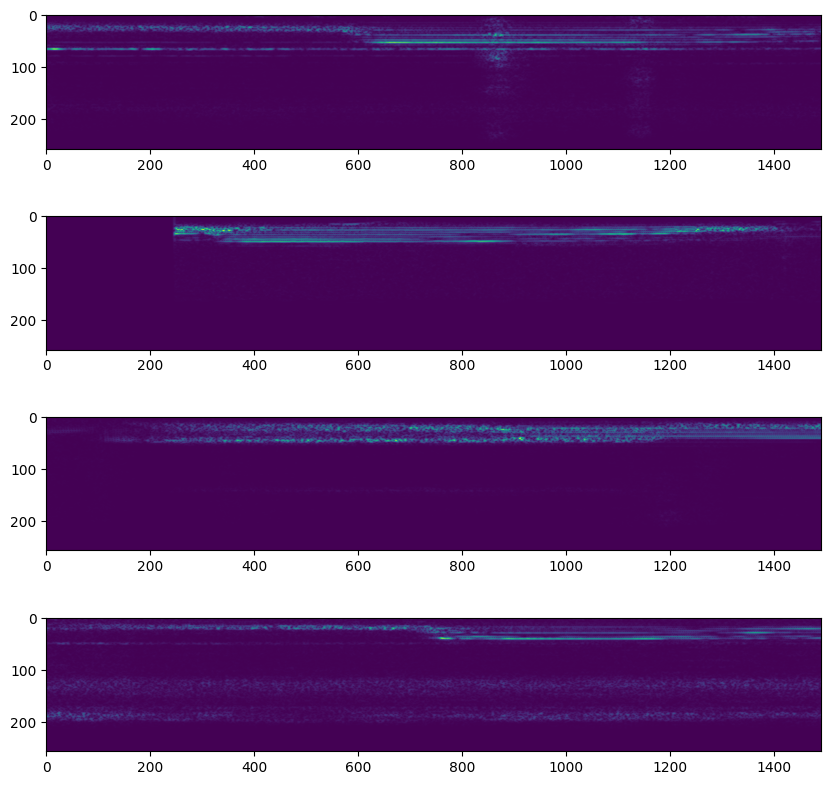

In [73]:
# plot the capuchin spectrograms
fig, ax = plt.subplots(4,1, figsize=(10,10))
for i in range(4):
  spec = spectrogram_convert(wav_trimming(load_data(os.path.join('data', 'Parsed_Capuchinbird_Clips', capu_sampled[i]))))
  ax[i].imshow(tf.transpose(spec)[0])

### Non-Capuchin

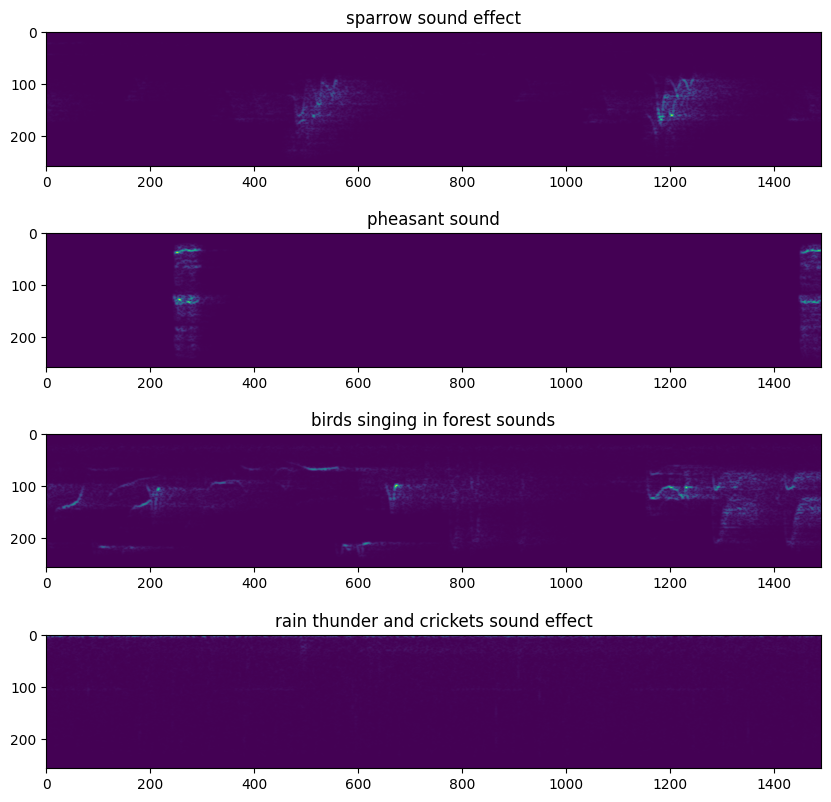

In [74]:
# plot the capuchin spectrograms
fig, ax = plt.subplots(4,1, figsize=(10,10))
for i in range(4):
  spec = spectrogram_convert(wav_trimming(load_data(os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', non_capu_sampled[i]))))
  ax[i].imshow(tf.transpose(spec)[0])
  ax[i].set_title(process_filename(non_capu_sampled[i]))